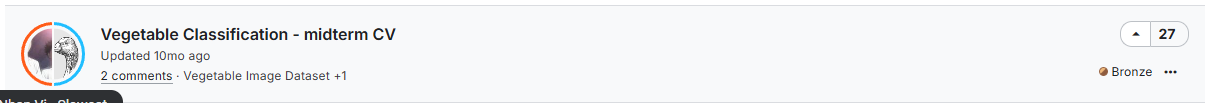

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os
import cv2
import glob
import warnings
import json
import timm

from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torchvision import datasets, models
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
#from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torcheval.metrics.functional import multiclass_f1_score
#from facenet_pytorch import InceptionResnetV1
from torchsummary import summary
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import ViTImageProcessor, ViTModel

from skimage import io
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
from skimage.io import imread

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.optimization")

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class config:
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    TEST_BATCH_SIZE = 1
    EPOCHS = 50
    SEED = 42
    MODEL_PATH = "model.bin"
    IMAGE_TRAIN_PATH = 'D:\code_study\ML_CODE\dataSets\Vegetable_Image_Dataset\Vegetable Images/train'
    IMAGE_TRAIN_PATH = IMAGE_TRAIN_PATH.replace('\\','/')
    IMAGE_TEST_PATH = 'D:\code_study\ML_CODE\dataSets\Vegetable_Image_Dataset\Vegetable Images/test'
    IMAGE_TEST_PATH = IMAGE_TEST_PATH.replace('\\','/')
    IMAGE_VALID_PATH = 'D:\code_study\ML_CODE\dataSets\Vegetable_Image_Dataset\Vegetable Images/validation'
    IMAGE_VALID_PATH = IMAGE_VALID_PATH.replace('\\','/')
    NUM_WORKERS = os.cpu_count()

torch.manual_seed(config.SEED)
torch.cuda.manual_seed(config.SEED)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
def count_images(path):
    total_images = 0
    for root, dirs, files in os.walk(path):
        total_images += len(files)
    return total_images

train_image_count = count_images(config.IMAGE_TRAIN_PATH)
test_image_count = count_images(config.IMAGE_TEST_PATH)
valid_image_count = count_images(config.IMAGE_VALID_PATH)

print("train:", train_image_count)
print("test:", test_image_count)
print("validation:", valid_image_count)

train: 15000
test: 3000
validation: 3000


In [4]:
def plot_random_image(target_dir):
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)
 
    plt.figure(figsize=(16,4))
    for i in range(5):
        
        plt.subplot(1,5,i+1)
        img=torchvision.io.read_image(os.path.join(target_folder,random_image[i]))
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'{target_class}\n{np.array(img).shape}')
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()

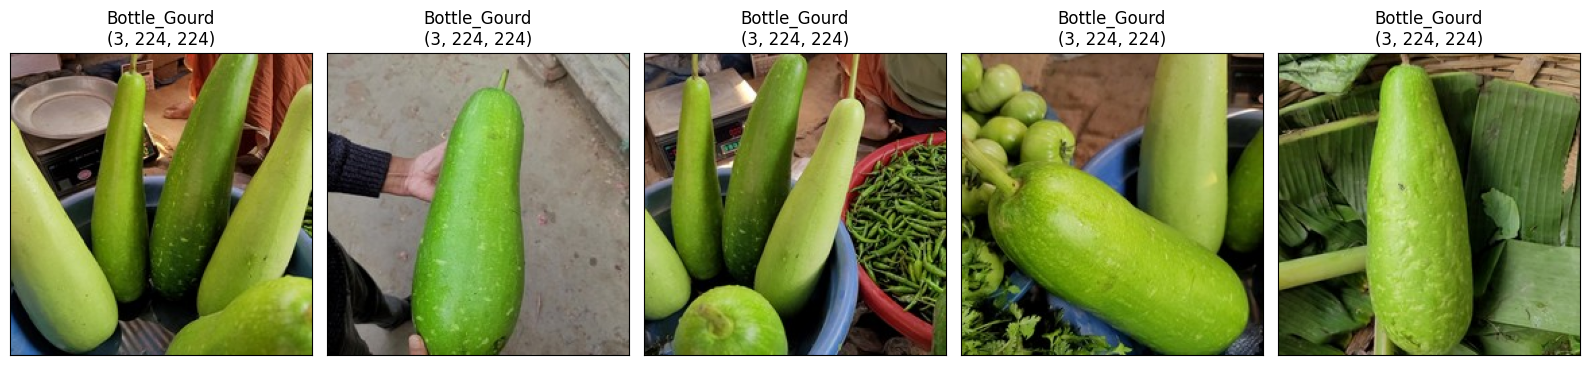

In [5]:
plot_random_image(config.IMAGE_TRAIN_PATH)

In [6]:
def count_images_per_class(images_path):
    subdirectories = [f.name for f in os.scandir(images_path) if f.is_dir()]
    class_counts = []

    for subdir in subdirectories:
        class_path = os.path.join(images_path, subdir)
        num_images = len(os.listdir(class_path))
        class_counts.append((subdir, num_images))
    
    return class_counts

def plot_class_distribution(class_counts):
    classes, counts = zip(*class_counts)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)

    # Add labels on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

    plt.show()

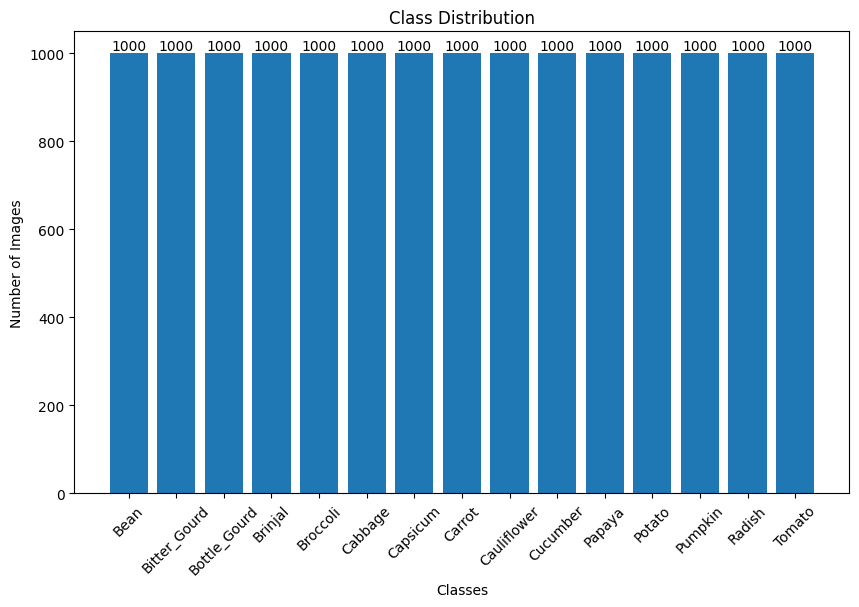

In [7]:
class_counts = count_images_per_class(config.IMAGE_TRAIN_PATH)
plot_class_distribution(class_counts)

In [8]:
augmentation_list=[transforms.RandomHorizontalFlip(p=1.0),
                   transforms.RandomRotation(15),
                   #transforms.ColorJitter(brightness=0.2,contrast=0.1,hue=0.1,saturation=0.1),
                   transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.5, 1.5), shear=15),
                   #transforms.GaussianBlur(kernel_size=(5,9)),
                  ]

In [9]:
def plot_original_and_aug_image(target_dir, aug_list):
    n=len(aug_list)
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir, target_class)
    random_image=random.sample(os.listdir(target_folder), n)
    
    
    for i in range(n):
        plt.figure(figsize=(16,6))
        augmentation=aug_list[i]
        plt.subplot(1,2,1)
        img=torchvision.io.read_image(os.path.join(target_folder,random_image[i]))
        img=img/255.0
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'Original Image\n{target_class}\n{np.array(img).shape}')
        plt.xticks([]);
        plt.yticks([])

        plt.subplot(1,2,2)

        img=augmentation(img)
        
        
        plt.imshow(np.array(img).transpose(1,2,0))
        plt.title(f'Augmented Image:{augmentation}\n{target_class}\n{np.array(img).shape}')
        plt.xticks([]);
        plt.yticks([])
        plt.show()

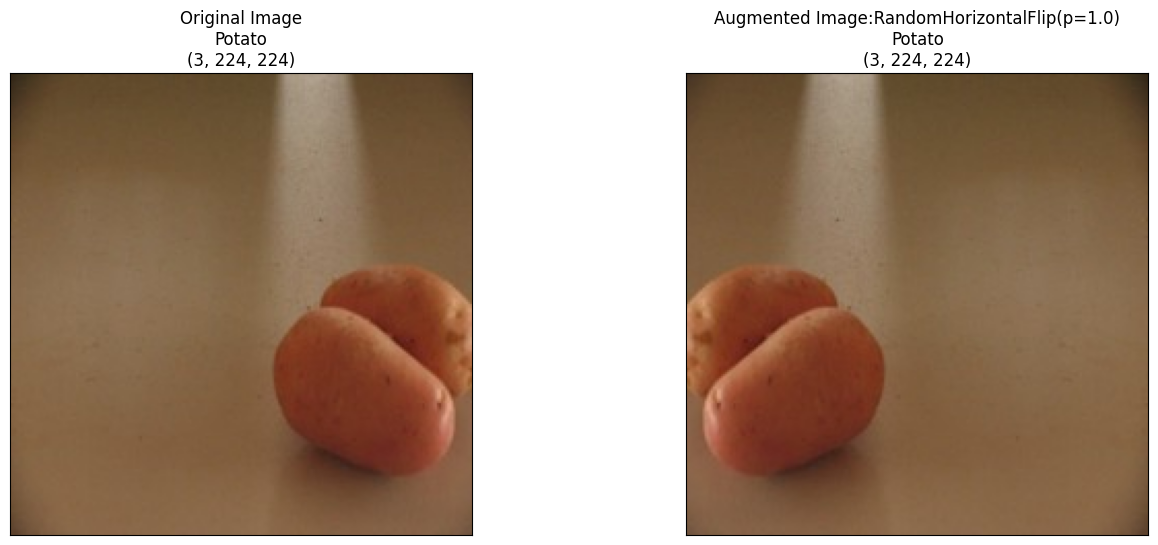

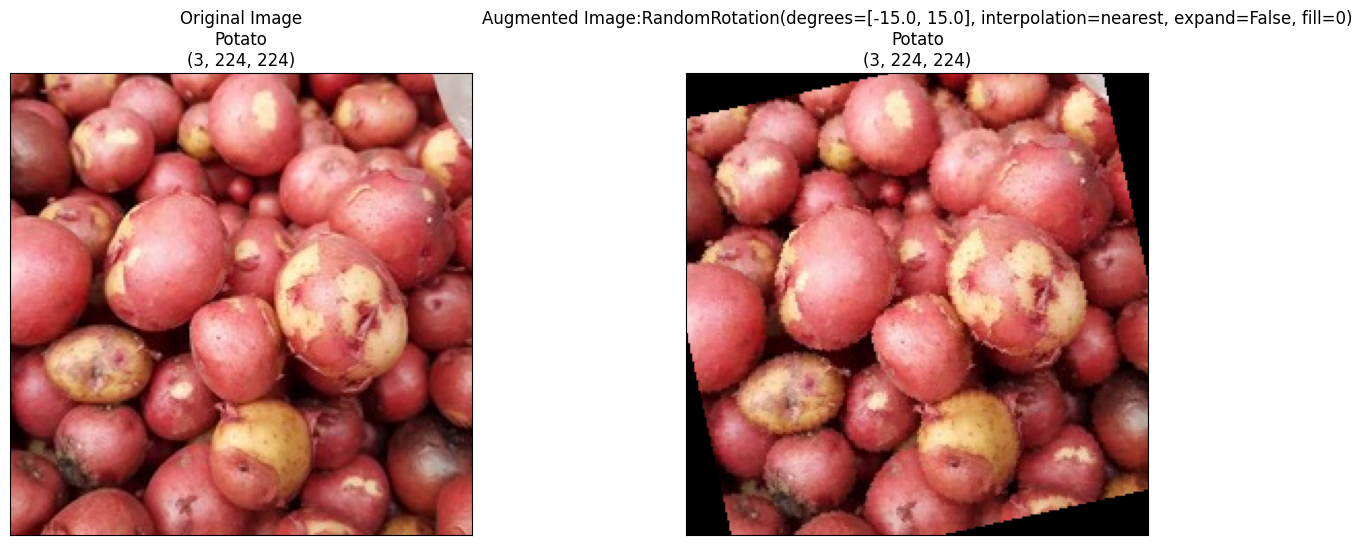

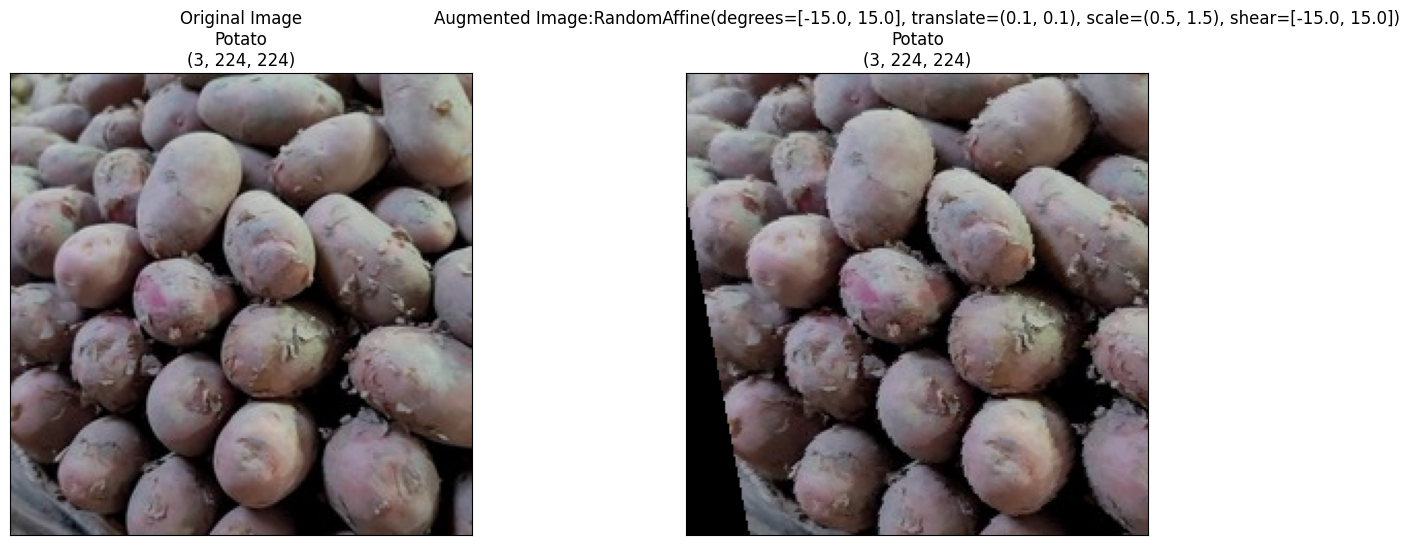

In [10]:
plot_original_and_aug_image(config.IMAGE_TRAIN_PATH, augmentation_list)

In [12]:
def enhance_images_with_clahe(input_folder, output_folder):
    # Hàm áp dụng CLAHE cho ảnh
    def apply_clahe(image):
        img = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        # Cấu hình CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        # 0 cho kênh 'L', 1 cho kênh 'a', và 2 cho kênh 'b'
        img[:,:,0] = clahe.apply(img[:,:,0])
        img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
        return img

    # Tạo thư mục output nếu chưa tồn tại
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Duyệt qua tất cả các thư mục trong thư mục input
    for class_folder in os.listdir(input_folder):
        # Đường dẫn đầy đủ tới thư mục của lớp 
        class_folder_path = os.path.join(input_folder, class_folder)
        # Duyệt qua tất cả các file trong thư mục của lớp
        for filename in os.listdir(class_folder_path):
            # Đường dẫn đầy đủ tới ảnh gốc
            input_path = os.path.join(class_folder_path, filename)
            # Đọc ảnh
            image = cv2.imread(input_path)
            if image is not None:
                # Áp dụng CLAHE
                clahe_image = apply_clahe(image)
                # Tạo đường dẫn đến thư mục lưu ảnh đã được tăng cường
                output_class_folder = os.path.join(output_folder, class_folder)
                # Tạo thư mục cho lớp nếu chưa tồn tại
                if not os.path.exists(output_class_folder):
                    os.makedirs(output_class_folder)
                # Đường dẫn đầy đủ tới ảnh đã được tăng cường
                output_path = os.path.join(output_class_folder, filename)
                # Lưu ảnh đã được tăng cường
                cv2.imwrite(output_path, clahe_image)


input_train = config.IMAGE_TRAIN_PATH
input_valid = config.IMAGE_VALID_PATH
input_test = config.IMAGE_TEST_PATH
output_path = 'D:\code_study\ML_CODE\dataSets\Vegetable_Image_Dataset\Vegetable Images\clahe'
output_path = output_path.replace('\\', '/')

output_train = output_path + '/train'
output_valid = output_path + '/validation'
output_test = output_path + '/test'
enhance_images_with_clahe(input_train, output_train)
enhance_images_with_clahe(input_valid, output_valid)
enhance_images_with_clahe(input_test, output_test)

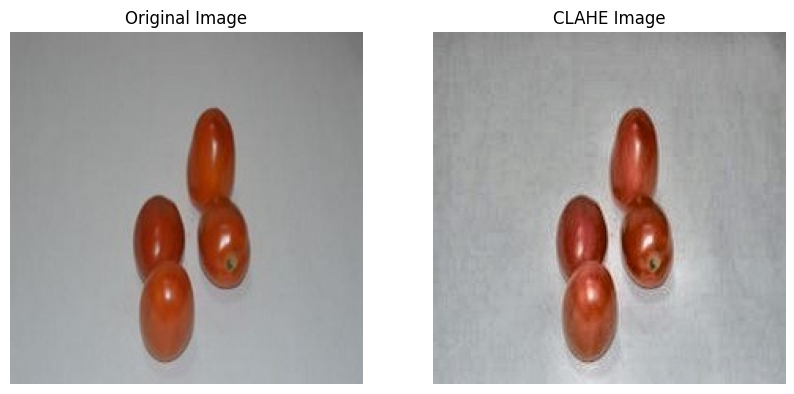

In [13]:
clahe_path = output_train + '/Tomato/0001.jpg'
origin_path = input_train + '/Tomato/0001.jpg'

clahe_image = cv2.imread(clahe_path)
origin_image = cv2.imread(origin_path)

# Chuyển đổi không gian màu từ BGR sang RGB (OpenCV đọc ảnh dưới dạng BGR)
clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

# Hiển thị ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(origin_image)
plt.title('Original Image')
plt.axis('off')

# Hiển thị ảnh sau khi xử lý CLAHE
plt.subplot(1, 2, 2)
plt.imshow(clahe_image)
plt.title('CLAHE Image')
plt.axis('off')

plt.show()

In [14]:
train_transform = transforms.Compose([#torchvision.transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Resize((224,224),antialias=True),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(15),
                                     #transforms.ColorJitter(brightness=0.2,contrast=0.1,hue=0.1,saturation=0.1),
                                     transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(1, 2), shear=15),
                                     #transforms.GaussianBlur(kernel_size=(5,9)),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(), 
                                     #torchvision.transforms.Normalize(mean,std)
                                     ])

In [15]:
train_dataset = ImageFolder(root=input_train, transform=train_transform)
valid_dataset = ImageFolder(root=input_valid, transform=test_transform)
test_dataset = ImageFolder(root=input_test, transform=test_transform)

In [16]:
class_names = train_dataset.classes
print("Classes name:", class_names)
print("Classes number:", len(class_names))

Classes name: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Classes number: 15


In [17]:
train_loader = DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.VALID_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.VALID_BATCH_SIZE, shuffle=False)

In [18]:
sample_image=iter(train_loader)
samples,labels = next(sample_image)
print(samples.shape)
print(labels)

torch.Size([16, 3, 224, 224])
tensor([ 7, 13,  6,  0, 14, 12, 14, 10,  0, 12, 13, 13,  5,  2,  6,  4])


In [19]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 15)
        #self.fc14 = nn.Linear(512, 15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        #print(x.size())
        x = x.reshape(x.shape[0], -1)
        #print(x.size())
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) 
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
#         x = self.avgpool(x)
        return x

In [20]:
model = VGG16().to(device)
#model = timm.create_model('hrnet_w18', pretrained=False, num_classes=15).to(device)
#model = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=False, num_classes=15).to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 56, 56]         590,080
        MaxPool2d-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-14          [-1, 512,

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.EPOCHS)

In [ ]:
best_accuracy = 0.0
best_model_state = None
train_loss_history = []
val_loss_history = []
f1_history = []

num_epochs = config.EPOCHS
for epoch in range(num_epochs):
    loss_var = 0
    correct = 0
    samples = 0
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device=device)
        labels = labels.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, labels)
        _, preds = scores.max(1)
        correct += (preds == labels).sum().item()
        samples += preds.size(0)
        loss.backward()
        optimizer.step()
        loss_var += loss.item()
        if idx % 64 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
    accuracy = float(correct) / float(samples)
    train_loss_history.append(loss_var / len(train_loader))
    print(f"Epoch {epoch+1} || Train Acc: {accuracy:.2f} || Train Loss: {loss_var/len(train_loader):.3f}")

    with torch.no_grad():
        correct = 0
        samples = 0
        val_loss_var = 0
        f1_score_var = 0
        for idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            f1 = multiclass_f1_score(outputs, labels.long(), num_classes=15, average="macro")
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            samples += preds.size(0)
            val_loss_var += val_loss.item()
            f1_score_var += f1.item()
        accuracy = float(correct) / float(samples)
        val_loss_history.append(val_loss_var / len(valid_loader))
        f1_history.append(f1_score_var / len(valid_loader))
        print(f"\t  Val Acc: {accuracy:.2f} || Val Loss: {val_loss_var/len(valid_loader):.3f} || F1-score: {f1_score_var / len(valid_loader):.2f} || Correct {correct} out of {samples} samples")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()

torch.save(best_model_state, 'best_model.pth')

Epoch [1/50] || Step [1/938] || Loss:0.002886093501597325
Epoch [1/50] || Step [65/938] || Loss:0.18765956049026455
Epoch [1/50] || Step [129/938] || Loss:0.37244501322317225
Epoch [1/50] || Step [193/938] || Loss:0.5572662724614906
Epoch [1/50] || Step [257/938] || Loss:0.742051258270166
Epoch [1/50] || Step [321/938] || Loss:0.9268728456517527
Epoch [1/50] || Step [385/938] || Loss:1.1116176454751476
Epoch [1/50] || Step [449/938] || Loss:1.2963897643058793
Epoch [1/50] || Step [513/938] || Loss:1.48105712409721
Epoch [1/50] || Step [577/938] || Loss:1.662136345021506
Epoch [1/50] || Step [641/938] || Loss:1.8349616425886337
Epoch [1/50] || Step [705/938] || Loss:2.004904913749776
Epoch [1/50] || Step [769/938] || Loss:2.1705618885788582
Epoch [1/50] || Step [833/938] || Loss:2.332739076888892
Epoch [1/50] || Step [897/938] || Loss:2.495484959977522


Epoch 1 || Train Acc: 0.10 || Train Loss: 2.598


	  Val Acc: 0.20 || Val Loss: 2.306 || F1-score: 0.12 || Correct 595 out of 3000 samples
Epoch [2/50] || Step [1/938] || Loss:0.002359977663198768
Epoch [2/50] || Step [65/938] || Loss:0.16237586139361743
Epoch [2/50] || Step [129/938] || Loss:0.32061281056800633
Epoch [2/50] || Step [193/938] || Loss:0.47640531607019876
Epoch [2/50] || Step [257/938] || Loss:0.6292246375510941
Epoch [2/50] || Step [321/938] || Loss:0.7861886526475838
Epoch [2/50] || Step [385/938] || Loss:0.9407071590677761
Epoch [2/50] || Step [449/938] || Loss:1.0950818204168062
Epoch [2/50] || Step [513/938] || Loss:1.250369602937434
Epoch [2/50] || Step [577/938] || Loss:1.4023514159961041
Epoch [2/50] || Step [641/938] || Loss:1.5528640688609467
Epoch [2/50] || Step [705/938] || Loss:1.6997378682022664
Epoch [2/50] || Step [769/938] || Loss:1.8457477644308289
Epoch [2/50] || Step [833/938] || Loss:1.9894477383160134
Epoch [2/50] || Step [897/938] || Loss:2.126261763481189


Epoch 2 || Train Acc: 0.20 || Train Loss: 2.215


	  Val Acc: 0.28 || Val Loss: 2.053 || F1-score: 0.20 || Correct 827 out of 3000 samples
Epoch [3/50] || Step [1/938] || Loss:0.0022916549812756113
Epoch [3/50] || Step [65/938] || Loss:0.13795956022449649
Epoch [3/50] || Step [129/938] || Loss:0.2701658462918898
Epoch [3/50] || Step [193/938] || Loss:0.40787386627339606
Epoch [3/50] || Step [257/938] || Loss:0.5385433228285328
Epoch [3/50] || Step [321/938] || Loss:0.6683138035762031
Epoch [3/50] || Step [385/938] || Loss:0.79762043055695
Epoch [3/50] || Step [449/938] || Loss:0.9239136248763437
Epoch [3/50] || Step [513/938] || Loss:1.0478356575915047
Epoch [3/50] || Step [577/938] || Loss:1.169017034680096
Epoch [3/50] || Step [641/938] || Loss:1.2904482026344168
Epoch [3/50] || Step [705/938] || Loss:1.4088734610756832
Epoch [3/50] || Step [769/938] || Loss:1.519422208195302
Epoch [3/50] || Step [833/938] || Loss:1.635109916170523
Epoch [3/50] || Step [897/938] || Loss:1.7479438630502615


Epoch 3 || Train Acc: 0.33 || Train Loss: 1.821


	  Val Acc: 0.44 || Val Loss: 1.595 || F1-score: 0.33 || Correct 1310 out of 3000 samples
Epoch [4/50] || Step [1/938] || Loss:0.0018540937254932135
Epoch [4/50] || Step [65/938] || Loss:0.11358754333656734
Epoch [4/50] || Step [129/938] || Loss:0.2155194588815734
Epoch [4/50] || Step [193/938] || Loss:0.31992045826495075
Epoch [4/50] || Step [257/938] || Loss:0.42155130617399966
Epoch [4/50] || Step [321/938] || Loss:0.5207797062041154
Epoch [4/50] || Step [385/938] || Loss:0.6183361651292488
Epoch [4/50] || Step [449/938] || Loss:0.7138306710765814
Epoch [4/50] || Step [513/938] || Loss:0.8102369014261119
Epoch [4/50] || Step [577/938] || Loss:0.9069307579287588
Epoch [4/50] || Step [641/938] || Loss:1.0009037064972208
Epoch [4/50] || Step [705/938] || Loss:1.091569335412369
Epoch [4/50] || Step [769/938] || Loss:1.1796635605378953
Epoch [4/50] || Step [833/938] || Loss:1.271046726180038
Epoch [4/50] || Step [897/938] || Loss:1.3618137873947493


Epoch 4 || Train Acc: 0.49 || Train Loss: 1.417


	  Val Acc: 0.53 || Val Loss: 1.318 || F1-score: 0.42 || Correct 1590 out of 3000 samples
Epoch [5/50] || Step [1/938] || Loss:0.0012713890594205877
Epoch [5/50] || Step [65/938] || Loss:0.08672617143913627
Epoch [5/50] || Step [129/938] || Loss:0.17280052573696128
Epoch [5/50] || Step [193/938] || Loss:0.2576410685902211
Epoch [5/50] || Step [257/938] || Loss:0.3415037281096363
Epoch [5/50] || Step [321/938] || Loss:0.4244787511922149
Epoch [5/50] || Step [385/938] || Loss:0.5079310115720672
Epoch [5/50] || Step [449/938] || Loss:0.5890676880569092
Epoch [5/50] || Step [513/938] || Loss:0.6715397804911966
Epoch [5/50] || Step [577/938] || Loss:0.7540793525003421
Epoch [5/50] || Step [641/938] || Loss:0.8358109629929447
Epoch [5/50] || Step [705/938] || Loss:0.9206857999314123
Epoch [5/50] || Step [769/938] || Loss:0.9986161405026023
Epoch [5/50] || Step [833/938] || Loss:1.073926859032879
Epoch [5/50] || Step [897/938] || Loss:1.1499080937236612


Epoch 5 || Train Acc: 0.58 || Train Loss: 1.201


	  Val Acc: 0.62 || Val Loss: 1.092 || F1-score: 0.52 || Correct 1862 out of 3000 samples
Epoch [6/50] || Step [1/938] || Loss:0.0006409789453437334
Epoch [6/50] || Step [65/938] || Loss:0.07793205480839906
Epoch [6/50] || Step [129/938] || Loss:0.15431739291402577
Epoch [6/50] || Step [193/938] || Loss:0.22904855044665876
Epoch [6/50] || Step [257/938] || Loss:0.305292089292998
Epoch [6/50] || Step [321/938] || Loss:0.3739930399572417
Epoch [6/50] || Step [385/938] || Loss:0.4530031462468064
Epoch [6/50] || Step [449/938] || Loss:0.5239126932010976
Epoch [6/50] || Step [513/938] || Loss:0.5949260205792974
Epoch [6/50] || Step [577/938] || Loss:0.67234402421568
Epoch [6/50] || Step [641/938] || Loss:0.7452690347489009
Epoch [6/50] || Step [705/938] || Loss:0.8215704657502775
Epoch [6/50] || Step [769/938] || Loss:0.8879806105134838
Epoch [6/50] || Step [833/938] || Loss:0.9569486775187287
Epoch [6/50] || Step [897/938] || Loss:1.027416946537205


Epoch 6 || Train Acc: 0.62 || Train Loss: 1.075


	  Val Acc: 0.68 || Val Loss: 0.944 || F1-score: 0.58 || Correct 2026 out of 3000 samples
Epoch [7/50] || Step [1/938] || Loss:0.0010945380115305692
Epoch [7/50] || Step [65/938] || Loss:0.0686901147558745
Epoch [7/50] || Step [129/938] || Loss:0.1337922363202455
Epoch [7/50] || Step [193/938] || Loss:0.20057607240387118
Epoch [7/50] || Step [257/938] || Loss:0.2696915517356604
Epoch [7/50] || Step [321/938] || Loss:0.33634152319004285
Epoch [7/50] || Step [385/938] || Loss:0.4035792505181929
Epoch [7/50] || Step [449/938] || Loss:0.4653373305350224
Epoch [7/50] || Step [513/938] || Loss:0.529329674266803
Epoch [7/50] || Step [577/938] || Loss:0.6020409414318325
Epoch [7/50] || Step [641/938] || Loss:0.6674072398369246
Epoch [7/50] || Step [705/938] || Loss:0.7345766570967144
Epoch [7/50] || Step [769/938] || Loss:0.7990084360403292
Epoch [7/50] || Step [833/938] || Loss:0.8627593382589345
Epoch [7/50] || Step [897/938] || Loss:0.925010469485956


Epoch 7 || Train Acc: 0.66 || Train Loss: 0.966


	  Val Acc: 0.68 || Val Loss: 0.912 || F1-score: 0.58 || Correct 2043 out of 3000 samples
Epoch [8/50] || Step [1/938] || Loss:0.00094620397350173
Epoch [8/50] || Step [65/938] || Loss:0.06201257129340792
Epoch [8/50] || Step [129/938] || Loss:0.12564339989156864
Epoch [8/50] || Step [193/938] || Loss:0.18930168643689105
Epoch [8/50] || Step [257/938] || Loss:0.2555838273341722
Epoch [8/50] || Step [321/938] || Loss:0.31739764487438366
Epoch [8/50] || Step [385/938] || Loss:0.3815709136124613
Epoch [8/50] || Step [449/938] || Loss:0.4403707988734947
Epoch [8/50] || Step [513/938] || Loss:0.49767377956716746
Epoch [8/50] || Step [577/938] || Loss:0.5569824772730056
Epoch [8/50] || Step [641/938] || Loss:0.6207814824733653
Epoch [8/50] || Step [705/938] || Loss:0.6816015972384512
Epoch [8/50] || Step [769/938] || Loss:0.7350664939771074
Epoch [8/50] || Step [833/938] || Loss:0.793290537684711
Epoch [8/50] || Step [897/938] || Loss:0.8515622285701064


Epoch 8 || Train Acc: 0.69 || Train Loss: 0.888


	  Val Acc: 0.62 || Val Loss: 1.093 || F1-score: 0.52 || Correct 1864 out of 3000 samples
Epoch [9/50] || Step [1/938] || Loss:0.0013822525549036608
Epoch [9/50] || Step [65/938] || Loss:0.06057741345245955
Epoch [9/50] || Step [129/938] || Loss:0.11542321455631174
Epoch [9/50] || Step [193/938] || Loss:0.17564693322059696
Epoch [9/50] || Step [257/938] || Loss:0.2297591932419775
Epoch [9/50] || Step [321/938] || Loss:0.2844459705197735
Epoch [9/50] || Step [385/938] || Loss:0.3398626031143579
Epoch [9/50] || Step [449/938] || Loss:0.3954082317253166
Epoch [9/50] || Step [513/938] || Loss:0.4532497936029678
Epoch [9/50] || Step [577/938] || Loss:0.5098336410960917
Epoch [9/50] || Step [641/938] || Loss:0.5618549140531626
Epoch [9/50] || Step [705/938] || Loss:0.6135270637489839
Epoch [9/50] || Step [769/938] || Loss:0.6725915192223307
Epoch [9/50] || Step [833/938] || Loss:0.7229245901743232
Epoch [9/50] || Step [897/938] || Loss:0.7844570001750104


Epoch 9 || Train Acc: 0.71 || Train Loss: 0.820


	  Val Acc: 0.75 || Val Loss: 0.720 || F1-score: 0.65 || Correct 2245 out of 3000 samples
Epoch [10/50] || Step [1/938] || Loss:0.0007112440524070756
Epoch [10/50] || Step [65/938] || Loss:0.05282583098802993
Epoch [10/50] || Step [129/938] || Loss:0.10323037016493425
Epoch [10/50] || Step [193/938] || Loss:0.15618578436722888
Epoch [10/50] || Step [257/938] || Loss:0.20927014821437376
Epoch [10/50] || Step [321/938] || Loss:0.26279010356807
Epoch [10/50] || Step [385/938] || Loss:0.3178370610705571
Epoch [10/50] || Step [449/938] || Loss:0.36559303333637305
Epoch [10/50] || Step [513/938] || Loss:0.42473663554898206
Epoch [10/50] || Step [577/938] || Loss:0.4773864320028565
Epoch [10/50] || Step [641/938] || Loss:0.5236853945102773
Epoch [10/50] || Step [705/938] || Loss:0.5732440631399786
Epoch [10/50] || Step [769/938] || Loss:0.6178752559620434
Epoch [10/50] || Step [833/938] || Loss:0.6697522230080958
Epoch [10/50] || Step [897/938] || Loss:0.7192015886973979


Epoch 10 || Train Acc: 0.74 || Train Loss: 0.750


	  Val Acc: 0.73 || Val Loss: 0.742 || F1-score: 0.63 || Correct 2193 out of 3000 samples
Epoch [11/50] || Step [1/938] || Loss:0.0013308903810057813
Epoch [11/50] || Step [65/938] || Loss:0.050621381986624144
Epoch [11/50] || Step [129/938] || Loss:0.09845733299438379
Epoch [11/50] || Step [193/938] || Loss:0.14769855468893356
Epoch [11/50] || Step [257/938] || Loss:0.20046404499743284
Epoch [11/50] || Step [321/938] || Loss:0.24795288932539505
Epoch [11/50] || Step [385/938] || Loss:0.2978961341289569
Epoch [11/50] || Step [449/938] || Loss:0.34436444062858756
Epoch [11/50] || Step [513/938] || Loss:0.38963787556330026
Epoch [11/50] || Step [577/938] || Loss:0.43543690871963625
Epoch [11/50] || Step [641/938] || Loss:0.4887130497488132
Epoch [11/50] || Step [705/938] || Loss:0.5358216098662633
Epoch [11/50] || Step [769/938] || Loss:0.5848694161406712
Epoch [11/50] || Step [833/938] || Loss:0.6356319655646393
Epoch [11/50] || Step [897/938] || Loss:0.6817916574349789


Epoch 11 || Train Acc: 0.75 || Train Loss: 0.714


	  Val Acc: 0.74 || Val Loss: 0.744 || F1-score: 0.65 || Correct 2225 out of 3000 samples
Epoch [12/50] || Step [1/938] || Loss:0.0004927605898903886
Epoch [12/50] || Step [65/938] || Loss:0.045137717033118835
Epoch [12/50] || Step [129/938] || Loss:0.09282715505819077
Epoch [12/50] || Step [193/938] || Loss:0.13388666696449333
Epoch [12/50] || Step [257/938] || Loss:0.17747564952193037
Epoch [12/50] || Step [321/938] || Loss:0.2232673863358081
Epoch [12/50] || Step [385/938] || Loss:0.2665060173029076
Epoch [12/50] || Step [449/938] || Loss:0.31783876325021676
Epoch [12/50] || Step [513/938] || Loss:0.359983837363054
Epoch [12/50] || Step [577/938] || Loss:0.40468238993112976
Epoch [12/50] || Step [641/938] || Loss:0.44678731359589074
Epoch [12/50] || Step [705/938] || Loss:0.4927018193770319
Epoch [12/50] || Step [769/938] || Loss:0.5395555483824663
Epoch [12/50] || Step [833/938] || Loss:0.5849304569682587
Epoch [12/50] || Step [897/938] || Loss:0.6298596973040465


Epoch 12 || Train Acc: 0.78 || Train Loss: 0.655


	  Val Acc: 0.76 || Val Loss: 0.693 || F1-score: 0.67 || Correct 2281 out of 3000 samples
Epoch [13/50] || Step [1/938] || Loss:0.0011976854379243179
Epoch [13/50] || Step [65/938] || Loss:0.03809628390998983
Epoch [13/50] || Step [129/938] || Loss:0.0824408823810915
Epoch [13/50] || Step [193/938] || Loss:0.12228301671077448
Epoch [13/50] || Step [257/938] || Loss:0.16122698469329744
Epoch [13/50] || Step [321/938] || Loss:0.19761492135618797
Epoch [13/50] || Step [385/938] || Loss:0.23820819922569972
Epoch [13/50] || Step [449/938] || Loss:0.2830984483856255
Epoch [13/50] || Step [513/938] || Loss:0.3234970358246044
Epoch [13/50] || Step [577/938] || Loss:0.3650798788790637
Epoch [13/50] || Step [641/938] || Loss:0.40536049553262654
Epoch [13/50] || Step [705/938] || Loss:0.4442645695481473
Epoch [13/50] || Step [769/938] || Loss:0.4822083345687847
Epoch [13/50] || Step [833/938] || Loss:0.5212810903168055
Epoch [13/50] || Step [897/938] || Loss:0.5608460075899101


Epoch 13 || Train Acc: 0.80 || Train Loss: 0.590


	  Val Acc: 0.79 || Val Loss: 0.622 || F1-score: 0.72 || Correct 2371 out of 3000 samples
Epoch [14/50] || Step [1/938] || Loss:0.0007470269828462906
Epoch [14/50] || Step [65/938] || Loss:0.03931029447550967
Epoch [14/50] || Step [129/938] || Loss:0.07835758961975448
Epoch [14/50] || Step [193/938] || Loss:0.11667661677037221
Epoch [14/50] || Step [257/938] || Loss:0.15946571918121025
Epoch [14/50] || Step [321/938] || Loss:0.19710346279558597
Epoch [14/50] || Step [385/938] || Loss:0.2379742253309628
Epoch [14/50] || Step [449/938] || Loss:0.2771346521879564
Epoch [14/50] || Step [513/938] || Loss:0.31755883592977197
Epoch [14/50] || Step [577/938] || Loss:0.35519020434127435
Epoch [14/50] || Step [641/938] || Loss:0.3921495275552085
Epoch [14/50] || Step [705/938] || Loss:0.43285680446289243
Epoch [14/50] || Step [769/938] || Loss:0.46926065053004445
Epoch [14/50] || Step [833/938] || Loss:0.5069055334051281
Epoch [14/50] || Step [897/938] || Loss:0.5437770160054093


Epoch 14 || Train Acc: 0.81 || Train Loss: 0.569


	  Val Acc: 0.80 || Val Loss: 0.601 || F1-score: 0.71 || Correct 2400 out of 3000 samples
Epoch [15/50] || Step [1/938] || Loss:0.0006636813886638389
Epoch [15/50] || Step [65/938] || Loss:0.04134902678954322
Epoch [15/50] || Step [129/938] || Loss:0.07613040341624319
Epoch [15/50] || Step [193/938] || Loss:0.10905284241938007
Epoch [15/50] || Step [257/938] || Loss:0.14157151899088039
Epoch [15/50] || Step [321/938] || Loss:0.17875548097481733
Epoch [15/50] || Step [385/938] || Loss:0.2144372092563905
Epoch [15/50] || Step [449/938] || Loss:0.2539907262436172
Epoch [15/50] || Step [513/938] || Loss:0.2901973711537209
Epoch [15/50] || Step [577/938] || Loss:0.3236464930853165
Epoch [15/50] || Step [641/938] || Loss:0.3641265164504745
Epoch [15/50] || Step [705/938] || Loss:0.39815559806520623
Epoch [15/50] || Step [769/938] || Loss:0.43329461627820537
Epoch [15/50] || Step [833/938] || Loss:0.4689900801578628
Epoch [15/50] || Step [897/938] || Loss:0.5034526156615029


Epoch 15 || Train Acc: 0.82 || Train Loss: 0.527


	  Val Acc: 0.83 || Val Loss: 0.509 || F1-score: 0.75 || Correct 2480 out of 3000 samples
Epoch [16/50] || Step [1/938] || Loss:0.0008236319779841376
Epoch [16/50] || Step [65/938] || Loss:0.032992469230249746
Epoch [16/50] || Step [129/938] || Loss:0.06986943417901932
Epoch [16/50] || Step [193/938] || Loss:0.10339875530395935
Epoch [16/50] || Step [257/938] || Loss:0.13820441243554482
Epoch [16/50] || Step [321/938] || Loss:0.17978276553819936
Epoch [16/50] || Step [385/938] || Loss:0.21763900281396756
Epoch [16/50] || Step [449/938] || Loss:0.2507789161985617
Epoch [16/50] || Step [513/938] || Loss:0.289070713446974
Epoch [16/50] || Step [577/938] || Loss:0.32072500500089324
Epoch [16/50] || Step [641/938] || Loss:0.3546705146524698
Epoch [16/50] || Step [705/938] || Loss:0.38720429536979845
Epoch [16/50] || Step [769/938] || Loss:0.4179453358197136
Epoch [16/50] || Step [833/938] || Loss:0.4499625603972213
Epoch [16/50] || Step [897/938] || Loss:0.48585447767523054


Epoch 16 || Train Acc: 0.83 || Train Loss: 0.507


	  Val Acc: 0.86 || Val Loss: 0.440 || F1-score: 0.78 || Correct 2576 out of 3000 samples
Epoch [17/50] || Step [1/938] || Loss:0.00026791995522309976
Epoch [17/50] || Step [65/938] || Loss:0.02783135304064639
Epoch [17/50] || Step [129/938] || Loss:0.059156179499588034
Epoch [17/50] || Step [193/938] || Loss:0.09087521898180945
Epoch [17/50] || Step [257/938] || Loss:0.12677852236735287
Epoch [17/50] || Step [321/938] || Loss:0.1569424063713947
Epoch [17/50] || Step [385/938] || Loss:0.18676010363185203
Epoch [17/50] || Step [449/938] || Loss:0.21438623729275105
Epoch [17/50] || Step [513/938] || Loss:0.24693422494078876
Epoch [17/50] || Step [577/938] || Loss:0.2768184173820433
Epoch [17/50] || Step [641/938] || Loss:0.3060451641774127
Epoch [17/50] || Step [705/938] || Loss:0.3379184006135474
Epoch [17/50] || Step [769/938] || Loss:0.3721661852764041
Epoch [17/50] || Step [833/938] || Loss:0.4029634432561362
Epoch [17/50] || Step [897/938] || Loss:0.43412244801661737


Epoch 17 || Train Acc: 0.85 || Train Loss: 0.453


	  Val Acc: 0.80 || Val Loss: 0.613 || F1-score: 0.72 || Correct 2390 out of 3000 samples
Epoch [18/50] || Step [1/938] || Loss:0.000463612234668691
Epoch [18/50] || Step [65/938] || Loss:0.03450370032681839
Epoch [18/50] || Step [129/938] || Loss:0.06427869024370779
Epoch [18/50] || Step [193/938] || Loss:0.0957889496041005
Epoch [18/50] || Step [257/938] || Loss:0.12136649214096669
Epoch [18/50] || Step [321/938] || Loss:0.15027127104368546
Epoch [18/50] || Step [385/938] || Loss:0.18132437552724565
Epoch [18/50] || Step [449/938] || Loss:0.21392686202772646
Epoch [18/50] || Step [513/938] || Loss:0.2427552045344798
Epoch [18/50] || Step [577/938] || Loss:0.2721323847993096
Epoch [18/50] || Step [641/938] || Loss:0.30371500948853075
Epoch [18/50] || Step [705/938] || Loss:0.33540651426195844
Epoch [18/50] || Step [769/938] || Loss:0.36415488417468855
Epoch [18/50] || Step [833/938] || Loss:0.39282772319514486
Epoch [18/50] || Step [897/938] || Loss:0.4218879832840487


Epoch 18 || Train Acc: 0.85 || Train Loss: 0.443


	  Val Acc: 0.85 || Val Loss: 0.434 || F1-score: 0.79 || Correct 2563 out of 3000 samples
Epoch [19/50] || Step [1/938] || Loss:0.00017354422922073398
Epoch [19/50] || Step [65/938] || Loss:0.02718735755538381
Epoch [19/50] || Step [129/938] || Loss:0.059015617425889094
Epoch [19/50] || Step [193/938] || Loss:0.08712268259717838
Epoch [19/50] || Step [257/938] || Loss:0.11669323760579263
Epoch [19/50] || Step [321/938] || Loss:0.14236707714146007
Epoch [19/50] || Step [385/938] || Loss:0.16963344207927109
Epoch [19/50] || Step [449/938] || Loss:0.19794658387997258
Epoch [19/50] || Step [513/938] || Loss:0.22309729388591323
Epoch [19/50] || Step [577/938] || Loss:0.25121702696643533
Epoch [19/50] || Step [641/938] || Loss:0.2791892626622656
Epoch [19/50] || Step [705/938] || Loss:0.3052954282691039
Epoch [19/50] || Step [769/938] || Loss:0.33758049152855046
Epoch [19/50] || Step [833/938] || Loss:0.36480162430927954
Epoch [19/50] || Step [897/938] || Loss:0.39475476370056045


Epoch 19 || Train Acc: 0.86 || Train Loss: 0.410


	  Val Acc: 0.87 || Val Loss: 0.402 || F1-score: 0.81 || Correct 2612 out of 3000 samples
Epoch [20/50] || Step [1/938] || Loss:0.00031082834134986404
Epoch [20/50] || Step [65/938] || Loss:0.030046536049037093
Epoch [20/50] || Step [129/938] || Loss:0.05688959852194608
Epoch [20/50] || Step [193/938] || Loss:0.08340608566078042
Epoch [20/50] || Step [257/938] || Loss:0.10949071631359775
Epoch [20/50] || Step [321/938] || Loss:0.1390186056041959
Epoch [20/50] || Step [385/938] || Loss:0.16699243009265172
Epoch [20/50] || Step [449/938] || Loss:0.19221078121919494
Epoch [20/50] || Step [513/938] || Loss:0.21817056859321177
Epoch [20/50] || Step [577/938] || Loss:0.24679715110104222
Epoch [20/50] || Step [641/938] || Loss:0.27162029988555386
Epoch [20/50] || Step [705/938] || Loss:0.2959425300478872
Epoch [20/50] || Step [769/938] || Loss:0.3221865216536181
Epoch [20/50] || Step [833/938] || Loss:0.3504398855438301
Epoch [20/50] || Step [897/938] || Loss:0.3809565379659631


Epoch 20 || Train Acc: 0.87 || Train Loss: 0.398


	  Val Acc: 0.90 || Val Loss: 0.310 || F1-score: 0.85 || Correct 2704 out of 3000 samples
Epoch [21/50] || Step [1/938] || Loss:0.000140630280666514
Epoch [21/50] || Step [65/938] || Loss:0.027038393542170525
Epoch [21/50] || Step [129/938] || Loss:0.0524669400354756
Epoch [21/50] || Step [193/938] || Loss:0.07606402212289223
Epoch [21/50] || Step [257/938] || Loss:0.10288089552302478
Epoch [21/50] || Step [321/938] || Loss:0.1280717530381133
Epoch [21/50] || Step [385/938] || Loss:0.15414228928543483
Epoch [21/50] || Step [449/938] || Loss:0.180371520365638
Epoch [21/50] || Step [513/938] || Loss:0.2092839198461029
Epoch [21/50] || Step [577/938] || Loss:0.23695871840391966
Epoch [21/50] || Step [641/938] || Loss:0.25971872226468157
Epoch [21/50] || Step [705/938] || Loss:0.2853077161294629
Epoch [21/50] || Step [769/938] || Loss:0.31081382272991415
Epoch [21/50] || Step [833/938] || Loss:0.3392622311160699
Epoch [21/50] || Step [897/938] || Loss:0.36166782569942446


Epoch 21 || Train Acc: 0.87 || Train Loss: 0.377


	  Val Acc: 0.89 || Val Loss: 0.320 || F1-score: 0.84 || Correct 2674 out of 3000 samples
Epoch [22/50] || Step [1/938] || Loss:0.0002868007749382621
Epoch [22/50] || Step [65/938] || Loss:0.02703578078321048
Epoch [22/50] || Step [129/938] || Loss:0.050465778203438845
Epoch [22/50] || Step [193/938] || Loss:0.07126649392883914
Epoch [22/50] || Step [257/938] || Loss:0.09486923568935664
Epoch [22/50] || Step [321/938] || Loss:0.1207448375909758
Epoch [22/50] || Step [385/938] || Loss:0.14514090623388856
Epoch [22/50] || Step [449/938] || Loss:0.1707404866032223
Epoch [22/50] || Step [513/938] || Loss:0.19258231694883565
Epoch [22/50] || Step [577/938] || Loss:0.2186025987520242
Epoch [22/50] || Step [641/938] || Loss:0.24692559887819898
Epoch [22/50] || Step [705/938] || Loss:0.2711435033103773
Epoch [22/50] || Step [769/938] || Loss:0.2975380165176764
Epoch [22/50] || Step [833/938] || Loss:0.32245455433064496
Epoch [22/50] || Step [897/938] || Loss:0.34482366790863944


Epoch 22 || Train Acc: 0.88 || Train Loss: 0.358


	  Val Acc: 0.88 || Val Loss: 0.386 || F1-score: 0.82 || Correct 2653 out of 3000 samples
Epoch [23/50] || Step [1/938] || Loss:0.0005888344128248788
Epoch [23/50] || Step [65/938] || Loss:0.022467400866753258
Epoch [23/50] || Step [129/938] || Loss:0.04624322261303854
Epoch [23/50] || Step [193/938] || Loss:0.06694745753349653
Epoch [23/50] || Step [257/938] || Loss:0.09078633593820305
Epoch [23/50] || Step [321/938] || Loss:0.11433892593836226
Epoch [23/50] || Step [385/938] || Loss:0.136362859359714
Epoch [23/50] || Step [449/938] || Loss:0.15675009258472716
Epoch [23/50] || Step [513/938] || Loss:0.18030916113080755
Epoch [23/50] || Step [577/938] || Loss:0.20338040737828403


In [ ]:
def plot_loss(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_loss(train_loss_history, val_loss_history)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
#model.load_state_dict(torch.load('/kaggle/input/midterm-pt/vgg_model.pth'))
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, preds = outputs.max(1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = accuracy_score(true_labels, predictions)
f1_value = f1_score(true_labels, predictions, average='macro')

print(f'Accuracy on test set: {accuracy:.2f}')
print(f'F1-score on test set: {f1_value:.2f}')

In [ ]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
input_image_path = input_test + '/Carrot/1002.jpg'

input_image = Image.open(input_image_path)
input_tensor = test_transform(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

with torch.no_grad():
    output = model(input_batch)
    _, predicted_class = output.max(1)

plt.imshow(input_image)
plt.title('Predicted class: ' + class_names[predicted_class.item()])
plt.axis('off')
plt.show()

In [ ]:
model=models.vgg16(pretrained=True)
#model = timm.create_model('hrnet_w18', pretrained=False, num_classes=15)
#model = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=False, num_classes=15)
#print(f'Model summary:\n{model.named_parameters}')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters.')